# Multi-Element Airfoil SDF Notebook

This notebook demonstrates how to compute and visualize the Signed Distance Field (SDF) for a multi-element airfoil. The airfoil consists of a main element and a flap. We use a modular, object-oriented approach by defining a `Polygon` class to handle individual geometries and a `MultiplePolygons` class to combine them (using the minimum SDF for the union of shapes).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class MultiElementAirfoilSDF:
    """
    MultiElementAirfoilSDF loads a multielement airfoil from a file,
    defines separate polygons for the main element and the flap,
    The input file is assumed to have (approximately) four columns:
        main_x, main_y, flap_x, flap_y
    Some lines may have only two columns (main element only). In that case,
    the flap coordinates are set to NaN.
    """
    def __init__(self, filepath):
        self.filepath = filepath
        self.main_vertices = None  # (N,2) for main element
        self.flap_vertices = None  # (M,2) for flap element

    def load_and_reorder_data(self):
        # Use a manual loader that reads each line and pads missing values.
        data_list = []
        with open(self.filepath, 'r') as f:
            for line in f:
                # Strip and skip empty or comment lines.
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                tokens = line.split()
                # If only two tokens, assume flap data is missing.
                if len(tokens) == 2:
                    tokens += [np.nan, np.nan]
                # Otherwise, if there are four tokens, keep them.
                if len(tokens) < 4:
                    # Skip lines that don't have at least two numbers.
                    continue
                try:
                    row = [float(tok) for tok in tokens[:4]]
                    data_list.append(row)
                except Exception as e:
                    # Skip lines that cause errors.
                    continue
        
        if not data_list:
            raise ValueError("No valid data was found in the file.")
        data = np.array(data_list)
        # Expect columns: [main_x, main_y, flap_x, flap_y]
        # Extract main element coordinates (assume always present)
        main = data[:, 0:2]
        # Extract flap coordinates: select only rows where flap_x is not NaN.
        flap_mask = ~np.isnan(data[:, 2])
        flap = data[flap_mask, 2:4]
        
        # Reorder each polygon using the trailing edge index strategy.
        self.main_vertices = self._reorder_polygon(main)
        if flap.shape[0] > 0:
            self.flap_vertices = self._reorder_polygon(flap)
        else:
            self.flap_vertices = None

    def _reorder_polygon(self, pts):
        """
        Reorder a set of 2D points to form a closed polygon.
        Assumes the upper surface is from leading edge to trailing edge.
        Splits the points at the index where x is maximum.
        """
        # Find the trailing edge (largest x coordinate)
        trailing_edge_index = np.argmax(pts[:, 0])
        upper = pts[:trailing_edge_index+1]
        lower = pts[trailing_edge_index+1:][::-1]
        poly = np.vstack((upper, lower))
        # Remove duplicate endpoint if present.
        if np.linalg.norm(poly[0] - poly[-1]) < 1e-6:
            poly = poly[:-1]
        return poly
    
file_path = '/home/dmsm/gi.catalani/Projects/multielement_inr/fowler_flap_airfoil.txt'
multi_airfoil = MultiElementAirfoilSDF(file_path)
multi_airfoil.load_and_reorder_data()
multi_airfoil_main = multi_airfoil.main_vertices
multi_airfoil_flap = multi_airfoil.flap_vertices

Once the polygons are ready we can sample the points and compute the SDFs.

In [2]:
from sdf_utils import Polygon

main_element_polygon = Polygon(multi_airfoil_main)
flap_element_polygon = Polygon(multi_airfoil_flap)

main_points, main_sdf = main_element_polygon.sample_points(num_points=10000)
flap_points, flap_sdf = flap_element_polygon.sample_points(num_points=10000)



Visualization of the main element

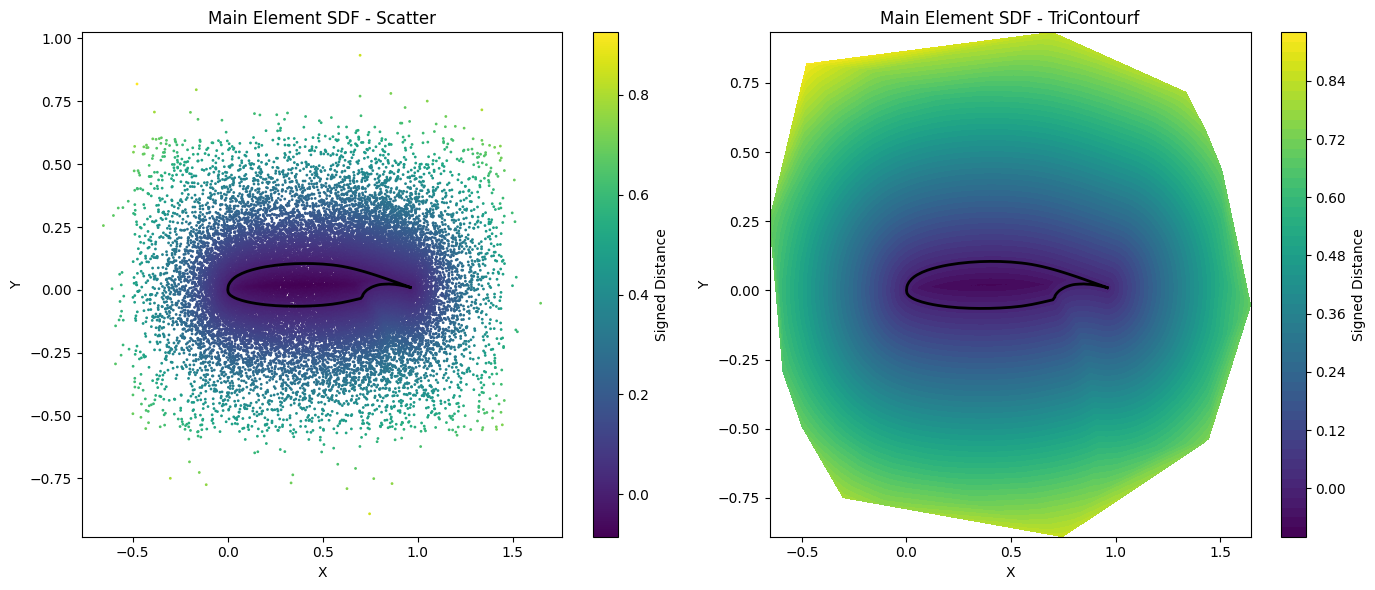

In [6]:
def get_closed_boundary(vertices):
    """Return vertices with the first vertex appended to close the loop."""
    return np.vstack((vertices, vertices[0]))

main_boundary = get_closed_boundary(multi_airfoil_main)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for main element SDF.
sc = ax1.scatter(main_points[:, 0], main_points[:, 1], c=main_sdf,
                 cmap='viridis', s=1)
ax1.plot(main_boundary[:, 0], main_boundary[:, 1], 'k-', lw=2)
ax1.set_title("Main Element SDF - Scatter")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
plt.colorbar(sc, ax=ax1, label="Signed Distance")

# TriContourf plot for main element SDF.
tc = ax2.tricontourf(main_points[:, 0], main_points[:, 1], main_sdf,
                     levels=50, cmap='viridis')
ax2.plot(main_boundary[:, 0], main_boundary[:, 1], 'k-', lw=2)
ax2.set_title("Main Element SDF - TriContourf")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
plt.colorbar(tc, ax=ax2, label="Signed Distance")

plt.tight_layout()
plt.show()


SDF of Multiple elements can be computed using the MultiplePolygons class

In [4]:
from sdf_utils import MultiplePolygons

multi_airfoil_polygons = MultiplePolygons([main_element_polygon, flap_element_polygon])

multi_points, multi_sdf = multi_airfoil_polygons.sample_points(num_points=10000)


Visualization

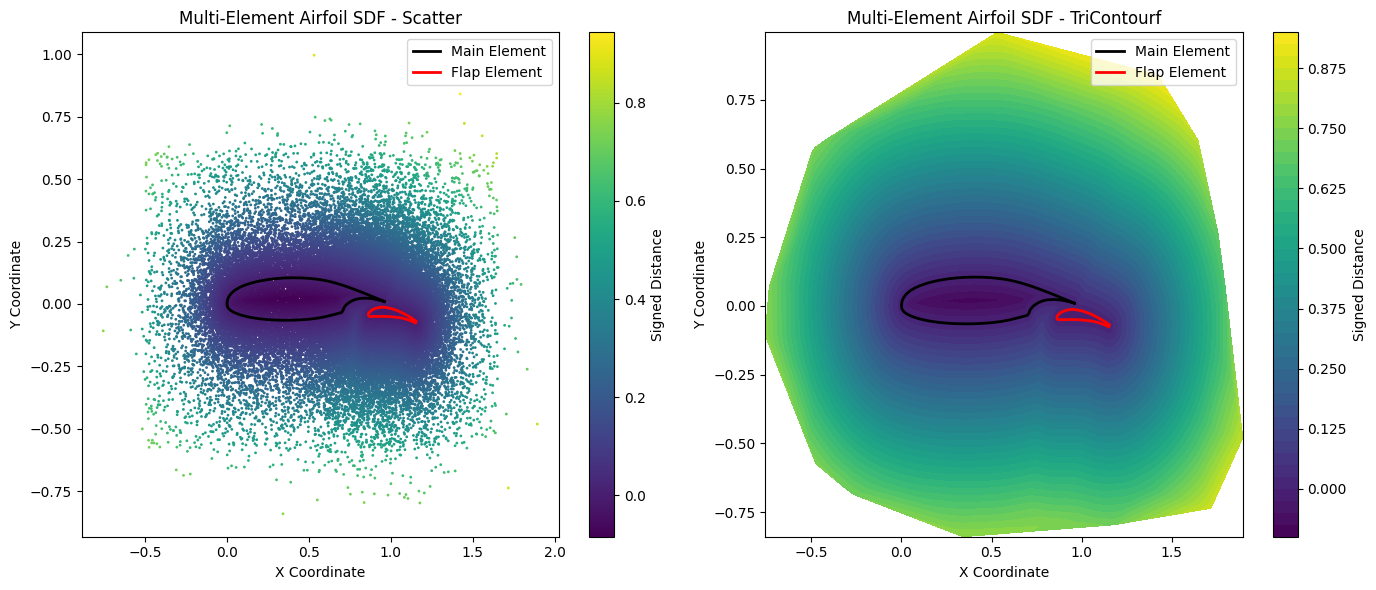

In [5]:
def get_closed_boundary(vertices):
    """Return vertices with the first vertex appended to close the loop."""
    return np.vstack((vertices, vertices[0]))

main_boundary = get_closed_boundary(multi_airfoil_main)
flap_boundary = get_closed_boundary(multi_airfoil_flap)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sc = ax1.scatter(multi_points[:, 0], multi_points[:, 1], c=multi_sdf, 
                 cmap='viridis', s=1)
ax1.plot(main_boundary[:, 0], main_boundary[:, 1], 'k-', lw=2, label='Main Element')
ax1.plot(flap_boundary[:, 0], flap_boundary[:, 1], 'r-', lw=2, label='Flap Element')
ax1.set_title("Multi-Element Airfoil SDF - Scatter")
ax1.set_xlabel("X Coordinate")
ax1.set_ylabel("Y Coordinate")
ax1.legend()
fig.colorbar(sc, ax=ax1, label="Signed Distance")

tc = ax2.tricontourf(multi_points[:, 0], multi_points[:, 1], multi_sdf, 
                     levels=50, cmap='viridis')
ax2.plot(main_boundary[:, 0], main_boundary[:, 1], 'k-', lw=2, label='Main Element')
ax2.plot(flap_boundary[:, 0], flap_boundary[:, 1], 'r-', lw=2, label='Flap Element')
ax2.set_title("Multi-Element Airfoil SDF - TriContourf")
ax2.set_xlabel("X Coordinate")
ax2.set_ylabel("Y Coordinate")
ax2.legend()
fig.colorbar(tc, ax=ax2, label="Signed Distance")

plt.tight_layout()
plt.show()